In [1]:
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

%matplotlib inline

In [2]:
sc = SparkContext()
sqlsc = SQLContext(sc)
spark = sqlsc.sparkSession

In [3]:
# Import dataset from parquet
df = spark.read.load('train.parquet')

# 1. Engineering data 

## 1.1. Missing values

In [4]:
dff = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
dff = dff.withColumn('Column', lit('Total')).toPandas().set_index('Column').transpose()
dff['Percent'] = (dff['Total']*100/df.count()).round(2)
dff.sort_values('Total', ascending = False).head(30)

Column,Total,Percent
EXT_SOURCE_1,4360550,53.89
PREV_NFLAG_INSURED_ON_APPROVAL,3442496,42.54
PREV_DAYS_TERMINATION,3442496,42.54
PREV_DAYS_LAST_DUE,3442496,42.54
OCCUPATION_TYPE,2602588,32.16
PREV_AMT_GOODS_PRICE,1861801,23.01
PREV_AMT_ANNUITY,1829413,22.61
BUREAU_DAYS_CREDIT_ENDDATE,683204,8.44
EXT_SOURCE_3,370453,4.58
BUREAU_AMT_CREDIT_SUM,175497,2.17


In [5]:
from pyspark.sql.types import StringType
str_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
num_cols = [x for x in df.columns if x not in str_cols]
idx_cols = [
    'SK_ID_CURR',
    'BUREAU_SK_ID_CURR', 'BUREAU_SK_ID_BUREAU',
    'PREV_SK_ID_CURR', 'PREV_SK_ID_PREV'
]
features = [x for x in num_cols if x not in ['TARGET'] + idx_cols]

## 1.2.  Numerical variables

<b> Correlation matrix

In [6]:
corr = []
for var in features:
    temps = df.stat.corr('TARGET', var)
    corr.append([var, temps])


cSchema = StructType([
    StructField("Variable", StringType()),
    StructField("Correlation", FloatType())
])

corr_tab = spark.createDataFrame(corr,schema=cSchema)\
                .withColumn('Absolute', F.abs(col('Correlation')))
# Print
corr_tab.orderBy('Absolute', ascending=False).show(len(features))

+--------------------+-------------+------------+
|            Variable|  Correlation|    Absolute|
+--------------------+-------------+------------+
|        EXT_SOURCE_3|  -0.17438422|  0.17438422|
|        EXT_SOURCE_2|  -0.14662737|  0.14662737|
|  BUREAU_DAYS_CREDIT|     0.067338|    0.067338|
|          DAYS_BIRTH|   0.06465716|  0.06465716|
|        EXT_SOURCE_1| -0.053362697| 0.053362697|
|DAYS_LAST_PHONE_C...|   0.04581558|  0.04581558|
|REG_CITY_NOT_WORK...|  0.037440337| 0.037440337|
|       DAYS_EMPLOYED|  -0.03494869|  0.03494869|
|   DAYS_REGISTRATION|  0.032477297| 0.032477297|
|REG_CITY_NOT_LIVE...|  0.030003462| 0.030003462|
|     AMT_GOODS_PRICE| -0.029813254| 0.029813254|
|BUREAU_DAYS_CREDI...|  0.028703833| 0.028703833|
|          AMT_CREDIT| -0.020801254| 0.020801254|
|PREV_NFLAG_INSURE...| -0.016091458| 0.016091458|
|        CNT_CHILDREN|  0.015917707| 0.015917707|
|     CNT_FAM_MEMBERS|  0.015748272| 0.015748272|
|    PREV_AMT_ANNUITY| -0.011781979| 0.011781979|


<b> In the following part, I select all numeric variables which have correlation coeff with `TARGET` more than 0.01 and plot a heat map.

In [7]:
numvar_col = corr_tab.where(col('Absolute') >= 0.01).select('Variable')
chosen_numvar = [numvar_col.collect()[i][0] for i in range(len(numvar_col.collect()))]

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

corr_columns = ['TARGET'] + chosen_numvar
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df.na.drop()).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), 
                        columns=corr_columns, 
                        index=corr_columns)
corr = correlation_matrix(df, corr_columns)

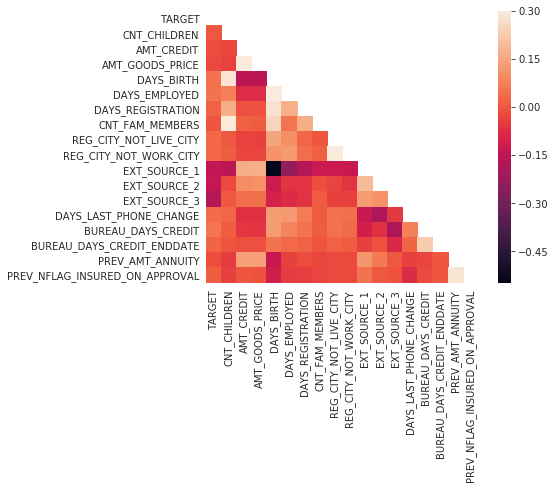

In [9]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

## 1.3. Categorical variables 

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=col, outputCol='CAT_'+col).fit(df.na.drop()) for col in str_cols]
pipeline = Pipeline(stages=indexers)
idx_df = pipeline.fit(df.na.drop()).transform(df.na.drop())
cat_cols = ['CAT_'+x for x in str_cols]

In [11]:
corr_cat = []
for var in cat_cols:
    temps = idx_df.stat.corr('TARGET', var)
    corr_cat.append([var, temps])

In [12]:
cSchema = StructType([
    StructField("Variable", StringType()),
    StructField("Correlation", FloatType())
])

catcorr = spark.createDataFrame(corr_cat,schema=cSchema).na.drop()
catcorr = catcorr.withColumn('Absolute', F.abs(catcorr.Correlation))
catcorr.orderBy('Absolute', ascending=False).show(len(cat_cols))

+--------------------+------------+------------+
|            Variable| Correlation|    Absolute|
+--------------------+------------+------------+
|CAT_NAME_EDUCATIO...|-0.047208134| 0.047208134|
|CAT_NAME_INCOME_TYPE|-0.037655972| 0.037655972|
|CAT_BUREAU_CREDIT...|  0.03424089|  0.03424089|
|CAT_NAME_CONTRACT...| -0.03369867|  0.03369867|
|    CAT_FLAG_OWN_CAR|-0.031940434| 0.031940434|
|CAT_PREV_NAME_CON...| 0.031785283| 0.031785283|
|     CAT_CODE_GENDER|  0.02024206|  0.02024206|
|CAT_NAME_HOUSING_...| 0.015710387| 0.015710387|
|CAT_BUREAU_CREDIT...|0.0149923675|0.0149923675|
|CAT_ORGANIZATION_...| -0.00686677|  0.00686677|
|CAT_NAME_FAMILY_S...|0.0035260892|0.0035260892|
| CAT_OCCUPATION_TYPE|-0.002623034| 0.002623034|
|CAT_PREV_NAME_CLI...| 0.001330584| 0.001330584|
| CAT_FLAG_OWN_REALTY| 5.733867E-4| 5.733867E-4|
+--------------------+------------+------------+



In [13]:
catvar_col = catcorr.filter(catcorr.Absolute >= 0.01).select('Variable')
chosen_catvar = [catvar_col.collect()[i][0] for i in range(len(catvar_col.collect()))]

import re
chosen_catevar = [re.compile(r"CAT_").sub("", m) for m in chosen_catvar]

## 1.4. Features engineering

In [14]:
features = ['TARGET'] + idx_cols + chosen_numvar + chosen_catevar
df_final = df.select(features).fillna(0, subset = chosen_numvar + idx_cols)

<b> All categorical variables, transform by `StringIndexer`

In [15]:
indexer = [StringIndexer(inputCol=col, outputCol='IDX_'+col).fit(df_final) for col in chosen_catevar]
pipeline = Pipeline(stages=indexer)
dff = pipeline.fit(df_final.na.drop()).transform(df_final.na.drop())

<b> Aggregation

In [16]:
str_var = ['IDX_' + x for x in chosen_catevar]
features = ['TARGET'] + idx_cols + chosen_numvar + str_var

In [17]:
df_agg = dff.groupBy(['SK_ID_CURR']).agg(
    avg(col('TARGET')).alias('TARGET'),
    F.count(col('BUREAU_SK_ID_BUREAU')).alias('NBR_SK_ID_BUREAU'),
    F.count(col('PREV_SK_ID_PREV')).alias('NBR_SK_ID_PREV'),
    avg(col('CNT_CHILDREN')).alias('CNT_CHILDREN'),
    avg(col('AMT_CREDIT')).alias('AMT_CREDIT'),
    avg(col('AMT_GOODS_PRICE')).alias('AMT_GOODS_PRICE'),
    avg(col('DAYS_BIRTH')).alias('DAYS_BIRTH'),
    avg(col('DAYS_EMPLOYED')).alias('DAYS_EMPLOYED'),
    avg(col('DAYS_REGISTRATION')).alias('DAYS_REGISTRATION'),
    avg(col('CNT_FAM_MEMBERS')).alias('CNT_FAM_MEMBERS'),
    avg(col('REG_CITY_NOT_LIVE_CITY')).alias('REG_CITY_NOT_LIVE_CITY'),
    avg(col('REG_CITY_NOT_WORK_CITY')).alias('REG_CITY_NOT_WORK_CITY'),
    avg(col('EXT_SOURCE_1')).alias('EXT_SOURCE_1'),
    avg(col('EXT_SOURCE_2')).alias('EXT_SOURCE_2'),
    avg(col('EXT_SOURCE_3')).alias('EXT_SOURCE_3'),
    avg(col('DAYS_LAST_PHONE_CHANGE')).alias('DAYS_LAST_PHONE_CHANGE'),
    avg(col('BUREAU_DAYS_CREDIT')).alias('M_BUREAU_DAYS_CREDIT'),
    avg(col('BUREAU_DAYS_CREDIT_ENDDATE')).alias('M_BUREAU_DAYS_CREDIT_ENDDATE'),
    avg(col('PREV_AMT_ANNUITY')).alias('M_PREV_AMT_ANNUITY'),
    avg(col('PREV_NFLAG_INSURED_ON_APPROVAL')).alias('M_PREV_NFLAG_INSURED_ON_APPROVAL'),
    avg(col('IDX_NAME_CONTRACT_TYPE')).alias('IDX_NAME_CONTRACT_TYPE'),
    avg(col('IDX_CODE_GENDER')).alias('IDX_CODE_GENDER'),
    avg(col('IDX_FLAG_OWN_CAR')).alias('IDX_FLAG_OWN_CAR'),
    avg(col('IDX_NAME_INCOME_TYPE')).alias('IDX_NAME_INCOME_TYPE'),
    avg(col('IDX_NAME_EDUCATION_TYPE')).alias('IDX_NAME_EDUCATION_TYPE'),
    avg(col('IDX_NAME_HOUSING_TYPE')).alias('IDX_NAME_HOUSING_TYPE'),
    avg(col('IDX_BUREAU_CREDIT_ACTIVE')).alias('M_IDX_BUREAU_CREDIT_ACTIVE'),
    avg(col('IDX_BUREAU_CREDIT_TYPE')).alias('M_IDX_BUREAU_CREDIT_TYPE'),
    avg(col('IDX_PREV_NAME_CONTRACT_TYPE')).alias('M_IDX_PREV_NAME_CONTRACT_TYPE')
)

In [18]:
df_agg.count()

249507

# 2. Models

## 2.1 Splitting train test sets

In [19]:
train, val = df_agg.randomSplit([0.85, 0.15], seed=12345)
print("Number of observations on train set: " + str(train.count()))
print("Number of observations on valid set: " + str(val.count()))

Number of observations on train set: 211847
Number of observations on valid set: 37660


In [20]:
from pyspark.ml.feature import VectorAssembler

input_cols = [x for x in df_agg.columns if x not in ['SK_ID_CURR', 'TARGET']]

assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
final_train = assembler.transform(train)
final_val = assembler.transform(val)

# 2.2. Logistic regression

In [21]:
from pyspark.ml.classification import LogisticRegression
logreg= LogisticRegression(featuresCol = 'features', labelCol = 'TARGET', maxIter=10)
LR_model = logreg.fit(final_train.selectExpr('features','TARGET'))

Training set areaUnderROC: 0.7140290948141219


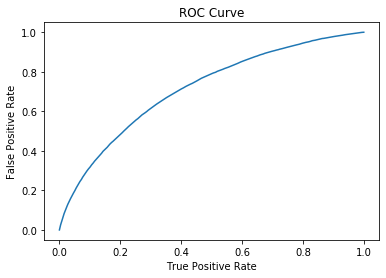

In [22]:
train_summary = LR_model.summary
roc = train_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
ROC_train1 = train_summary.areaUnderROC
print('Training set areaUnderROC: ' + str(train_summary.areaUnderROC))

In [23]:
predictions = LR_model.transform(final_val.selectExpr('features','TARGET'))
predictions.select('TARGET', 'rawPrediction', 'prediction', 'probability').show(5)

+------+--------------------+----------+--------------------+
|TARGET|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|   0.0|[2.31444247926879...|       0.0|[0.91006611645776...|
|   0.0|[2.17685006513194...|       0.0|[0.89815129123859...|
|   0.0|[2.6914138536605,...|       0.0|[0.93651808992752...|
|   0.0|[0.94417352178154...|       0.0|[0.71994191796805...|
|   0.0|[2.74883525778891...|       0.0|[0.93984753584523...|
+------+--------------------+----------+--------------------+
only showing top 5 rows



In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="TARGET", metricName="areaUnderROC")
ROC_val1 = evaluator.evaluate(predictions)
print('Validation set areaUnderROC: ' + str(ROC_val1))

Validation set areaUnderROC: 0.7163003419288025


In [26]:
# Storing result
res = []
res.append(['Logistic Regression', ROC_train1, ROC_val1])

## 2.3. Decision tree

In [27]:
from pyspark.ml.classification import DecisionTreeClassifier
DT = DecisionTreeClassifier(labelCol='TARGET', featuresCol='features', maxDepth = 3)
DT_model = DT.fit(final_train.selectExpr('features','TARGET'))

In [28]:
train_pred = DT_model.transform(final_train.selectExpr('features','TARGET'))
val_pred = DT_model.transform(final_val.selectExpr('features','TARGET'))
ROC_train2 = evaluator.evaluate(train_pred)
ROC_val2 = evaluator.evaluate(val_pred)
print('Training set areaUnderROC: ' + str(ROC_train2))
print('Validation set areaUnderROC: ' + str(ROC_val2))

Training set areaUnderROC: 0.5
Validation set areaUnderROC: 0.5


In [29]:
res.append(['Decision Tree', ROC_train2, ROC_val2])

## 2.4. Random Forest

In [30]:
from pyspark.ml.classification import RandomForestClassifier

RF = RandomForestClassifier(featuresCol='features', labelCol='TARGET')
RF_Model = RF.fit(final_train.selectExpr('features','TARGET'))

In [31]:
train_pred = RF_Model.transform(final_train.selectExpr('features','TARGET'))
val_pred = RF_Model.transform(final_val.selectExpr('features','TARGET'))
ROC_train3 = evaluator.evaluate(train_pred)
ROC_val3 = evaluator.evaluate(val_pred)

print('Training set areaUnderROC: ' + str(ROC_train3))
print('Validation set areaUnderROC: ' + str(ROC_val3))

Training set areaUnderROC: 0.6769100682370223
Validation set areaUnderROC: 0.6724854278710961


<Figure size 432x1080 with 0 Axes>

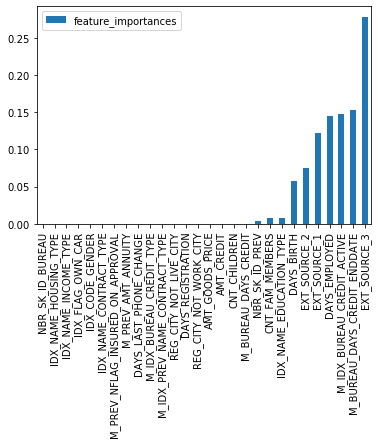

In [32]:
feature_importances = RF_Model.featureImportances
feature_names = input_cols

plt.figure(figsize=(6,15))
pd.DataFrame(data = list(feature_importances), 
             columns = ['feature_importances'], 
             index = feature_names).sort_values(by = 'feature_importances').plot.bar()

In [33]:
res.append(['Random Forest', ROC_train3, ROC_val3])

## Gradient-Boosted Tree Classifier

In [36]:
from pyspark.ml.classification import GBTClassifier

GBT = GBTClassifier(labelCol="TARGET", featuresCol='features', maxIter=10)
GBT_Model = GBT.fit(final_train.selectExpr('features','TARGET'))

In [37]:
train_pred = GBT_Model.transform(final_train.selectExpr('features','TARGET'))
val_pred = GBT_Model.transform(final_val.selectExpr('features','TARGET'))
ROC_train4 = evaluator.evaluate(train_pred)
ROC_val4 = evaluator.evaluate(val_pred)

In [38]:
res.append(['Gradient Boosted Tree', ROC_train4, ROC_val4])

In [39]:
pd.DataFrame(res, columns=['Model', 'ROC_train', 'ROC_test'])

,Model,ROC_train,ROC_test
0,Logistic Regression,0.714029,0.716300
1,Decision Tree,0.500000,0.500000
2,Random Forest,0.676910,0.672485
3,Gradient Boosted Tree,0.739511,0.731594


In conclusion, gradient boosted tree regression outperform all other models used. As can be seen on the plot of important features, during considering the credit applications, several factors such as all external resources, other personal information including age, employment duration, how large is their family, and their credit history (in internal credit institute and other credit bureau).

In this project, I do not do the hyperparameters tuning due to limited time and large data set.
